In [1]:
import torch
import torch.optim as optim
import torch.cuda as cuda
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from os.path import exists
from Dataset import FramesDataset
from convNet import convNet
from UNET import UNET

In [2]:
BATCH = 3
EPOCHS = 10
LR = 0.0001
device = "cuda" if cuda.is_available() else "cpu"
dir_dataset = '../dataset2'
dataset = FramesDataset(dir = dir_dataset, transform=transforms.ToTensor())
model = UNET(6,3).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [3]:
if(exists("./weights.pth")):
  model.load_state_dict(torch.load('./weights.pth'))

In [4]:
length = dataset.__len__()
test = length//10
train = length - test
trainset, testset = random_split(dataset,[train,test])
trainset = DataLoader(trainset, batch_size=BATCH, shuffle=True, pin_memory=True,num_workers=2)
testset = DataLoader(testset, batch_size=1, shuffle=True)

In [5]:
lossFunction = torch.nn.SmoothL1Loss()
totalLoss = []
for epoch in range(EPOCHS):
    epochLoss = []
    for data in trainset:
        (F1,F3) ,F2, (img1, img3) = data 
        input = torch.cat([F1.to(device), F3.to(device)], dim=1)
        output = model(input)
        loss  = lossFunction(output , F2.to(device))
        epochLoss.append(loss.item())
        loss.backward()
        optimizer. step()
        optimizer.zero_grad()
        del F1, F2, F3, loss, output,  img1, data
    print(sum(epochLoss)/len(epochLoss))
    totalLoss.append(sum(epochLoss)/len(epochLoss))

c:\Users\Mau\anaconda3\envs\Proyecto_Final.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.01012867910360607
0.0037026610186633962
0.003265966986655258
0.0027818790330396345
0.0027391490294636847
0.0026947377814212814
0.0026678659180955342
0.0026350274155265653
0.0025859421053125212
0.0025378133517612394


In [6]:
data = []
data = next(iter(testset))
((F1,F3) ,F2, (img1, img3)) = data
cuda.reset_peak_memory_stats(device="cuda")
with torch.no_grad():
    output = model(torch.cat([F1.to(device), F3.to(device)], dim=1))
img1 = F1.numpy()[0].transpose(1,2,0)
img2 = F2.cpu().numpy()[0].transpose(1,2,0)
img3 = F3.numpy()[0].transpose(1,2,0)
generated = output.cpu().detach().numpy()[0].transpose(1,2,0)
del F1, F2, F3, output, data
cuda.reset_peak_memory_stats(device="cuda")

c:\Users\Mau\anaconda3\envs\Proyecto_Final.venv\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Text(0.5, 1.0, 'generated')

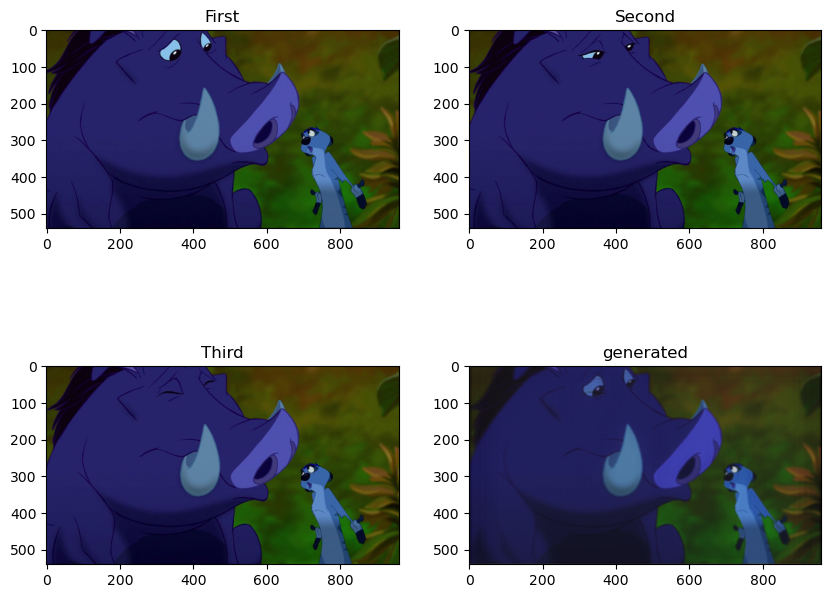

In [7]:
fig = plt.figure(figsize=(10, 8))
fig.add_subplot(2, 2, 1) 
plt.imshow(img1)
plt.title("First")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Second")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Third")
fig.add_subplot(2, 2, 4)
plt.imshow(generated)
plt.title("generated")

In [8]:
torch.save(model.state_dict(), "weights.pth")